<a href="https://colab.research.google.com/github/subornaa/Data-Analytics-Tutorials/blob/main/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning

# Introduction and Dataset

## Background

Landcover classification is a common method in remote sensing that uses satellite or aerial imagery to categorize to composition of the landscape. Landcover classification is especially important in the field of forestry to identify forested vs. non-forested areas, in addition to different forest types (e.g., coniferous vs. deciduous).

One approach to landcover classification is through supervised machine learning, such as random forest or support vector machines. However, this approach requires representative sample data to train an effective model. Moreover, this approach requires prior knowledge about the landscape in question in addition to how many unique landcover classes should be used.

Unsupervised learning on the other hand is effective for landcover classification because it does not require any training samples nor does it require a prior understanding of the landscape composition. As such, this makes unsupervised classification an effective initial, exploratory approach for landcover classification.

In this tutorial, we use k-means unsupervised learning to perform landcover classification in the Petawawa research forest (PRF) following similar methods to Burrough et. al (2001).

## Tutorial goals

**Goal 1: Apply K-means clustering to perform landcover classification using Sentinel-2 imagery over the PRF.**

**Goal 2: Apply the K-means clustering to the entire PRF**

**Goal 3: Evaluate and Validate Clustering Results**

**Goal 4: MiniBatchKMeans clustering**

**Goal 5: Classifying the Sentinel-2 image change between 2018 and 2024**

## Data

This tutorial makes use of Sentinel-2 multispectral imagery. See the README or website for more information about the Sentinel-2 dataset.

## References

Burrough, Peter A., et al. "Fuzzy k-means classification of topo-climatic data as an aid to forest mapping in the Greater Yellowstone Area, USA." Landscape ecology 16.6 (2001): 523-546.

In [ ]:
!pip install -q pandas==2.2.2
!pip install -q geopandas==1.0.1
!pip install -q matplotlib==3.10.1
!pip install -q rioxarray==0.19.0
!pip install -q spyndex==0.5.0
!pip install -q pyarrow==19.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.5/727.5 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.6/184.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 18.3 MB/s eta 0:00:00


In [ ]:
import rioxarray as rio
import numpy as np
from rasterio.plot import show
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

In [ ]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Downloading...
From (original): https://drive.google.com/uc?id=1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
From (redirected): https://drive.google.com/uc?id=1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2&confirm=t&uuid=72846a3e-0765-4cb0-aa91-1a9eaf1d86e4
To: /content/prf_data.zip
100% 150M/150M [00:01<00:00, 75.7MB/s]
Archive:  prf_data.zip
  inflating: data/als_metrics.tif    
  inflating: data/boundary.gpkg      
  inflating: data/forest_point_cloud.las  
  inflating: data/forest_point_cloud_footprint.gpkg  
  inflating: data/petawawa_s2_2018.tif  
  inflating: data/petawawa_s2_2024.tif  
  inflating: data/plots.gpkg         
  inflating: data/predictors.csv     
  inflating: data/trees.csv          
  inflating: data/water.gpkg         


['plots.gpkg',
 'petawawa_s2_2024.tif',
 'trees.csv',
 'als_metrics.tif',
 'predictors.csv',
 'forest_point_cloud.las',
 'forest_point_cloud_footprint.gpkg',
 'boundary.gpkg',
 'petawawa_s2_2018.tif',
 'water.gpkg']

Load the data and check the shape of the raster values

In [ ]:
s2_2018_fpath = 'data/petawawa_s2_2018.tif'

boundary_fpath = 'data/boundary.gpkg'

s2_2018 = rio.open_rasterio(s2_2018_fpath)

boundary_gdf = gpd.read_file(boundary_fpath).to_crs(s2_2018.rio.crs)
s2_2018.values.shape

(12, 937, 1824)

# Visualize the PRF Sentinel-2 imagery again

We are revisting the PRF Sentinel-2 imagery again which we explored in a previous tutorial. Lets first try to visulize it.

In [ ]:
# Define function to get simplified matplotlib output
def simplify_plt(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

<Axes: >

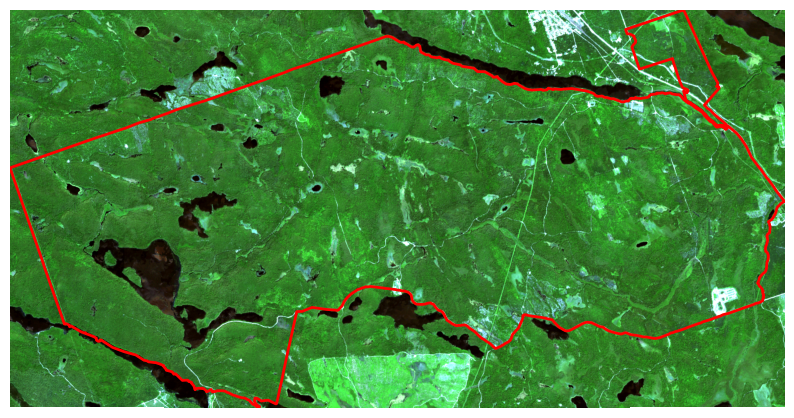

In [ ]:
# Perform a percentage clip to remove very bright/dark pixels and enhance image contrast
def plot_rgb(rgb, ax, low_perc=1, high_perc=99):

    #find the values to do contrast stretching
    vmin, vmax = np.nanpercentile(rgb, (low_perc, high_perc))

    #ensure values are between 0 and 1
    rgb = np.clip(rgb, vmin, vmax)

    # Visualize the PRF Sentinel-2 imagery
    show(rgb, ax=ax, transform=s2_2018.rio.transform(), adjust=True)


fig, ax = plt.subplots(figsize=(10, 10))

plot_rgb(s2_2018.values[1:4], ax=ax)

simplify_plt(ax)

boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

Now that we have an idea of the area we are looking at, lets further setup our experiment.

# Collect Samples of Image Pixels

In order to perform k-means clustering, we need to sample the image. We could theoretically use all the image pixels, but this would be too computationally demanding and likely redundant.

In [ ]:
# Check how many pixels are in the image
n_pixels = s2_2018.shape[1] * s2_2018.shape[2]

print(f'There are {n_pixels} in the image.')

There are 1709088 in the image.


To save time and compute, we can sample the image along an evenly spaced grid.

We want to classify all the pixels in the image, to do so we will start with a sample  of points

We will sample points on a grid with points spaced 300 meters apart.

 n = 2491 samples within the boundary.


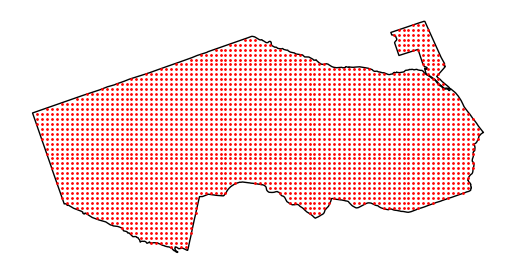

In [ ]:
spacing = 200

xmin, ymin, xmax, ymax = boundary_gdf.total_bounds

xcoords = [i for i in np.arange(xmin, xmax, spacing)]
ycoords = [i for i in np.arange(ymin, ymax, spacing)]

pointcoords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1, 2) #A 2D array like [[x1,y1], [x1,y2], ...
sample_pts = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])
sample_pts = gpd.GeoSeries(sample_pts, crs=boundary_gdf.crs)

sample_pts.name = 'geometry'

sample_pts = gpd.sjoin(gpd.GeoDataFrame(sample_pts), boundary_gdf[['geometry']], how="inner", predicate='within')

ax = boundary_gdf.plot(color='none', edgecolor='black')

sample_pts.plot(ax=ax, color='red', markersize=1)

simplify_plt(ax)

print(" n =", len(sample_pts), "samples within the boundary.")

# Extract pixel values from samples

This code below extracts pixel values for each band at the sample points.

In [ ]:
plot_coords = [(geom.x, geom.y) for geom in sample_pts.geometry]

sample_pixels_ls = [s2_2018.sel(x=c[0], y=c[1], method="nearest").values for c in plot_coords]

sample_pixels_arr = np.stack(sample_pixels_ls, axis=0)


samples_df = pd.DataFrame(sample_pixels_arr,
             columns=['Aerosols', 'Blue', 'Green', 'Red',
                      'Red Edge 1', 'Red Edge 2', 'Red Edge 3',
                      'NIR', 'Red Edge 4', 'Water vapor',
                      'SWIR 1', 'SWIR 2'])
samples_df


Aerosols     Blue    Green      Red  Red Edge 1  Red Edge 2  Red Edge 3  \
0      0.01505  0.02300  0.04800  0.01855     0.08155     0.32965     0.41315   
1      0.01250  0.01710  0.02980  0.01330     0.05425     0.20595     0.27335   
2      0.01405  0.01930  0.03420  0.01810     0.05875     0.20195     0.25340   
3      0.01400  0.02510  0.05825  0.02455     0.08955     0.33650     0.42485   
4      0.01325  0.01560  0.03225  0.01240     0.06875     0.25960     0.33925   
...        ...      ...      ...      ...         ...         ...         ...   
2486   0.01930  0.03255  0.05760  0.03365     0.08995     0.28525     0.35275   
2487   0.03490  0.06830  0.08780  0.08810     0.11805     0.26695     0.31635   
2488   0.01850  0.02310  0.04310  0.02115     0.06450     0.21775     0.28495   
2489   0.01885  0.02075  0.03705  0.01940     0.06795     0.23755     0.28725   
2490   0.02390  0.02425  0.03640  0.03100     0.07435     0.19810     0.24320   

          NIR  Red Edge 4  Water vapor   SWIR 1   SWIR 2  
0     0.40715     0.43460      0.37585  0.17235  0.07385  
1     0.27255     0.28695      0.35720  0.12945  0.05805  
2     0.26020     0.27805      0.32235  0.13330  0.06000  
3     0.47235     0.46075      0.41050  0.18310  0.08050  
4     0.31620     0.35280      0.37420  0.14335  0.06010  
...       ...         ...          ...      ...      ...  
2486  0.35565     0.38745      0.38660  0.16980  0.08015  
2487  0.27570     0.33510      0.34555  0.19275  0.13115  
2488  0.35025     0.30685      0.28200  0.12750  0.05980  
2489  0.33725     0.31320      0.34585  0.13735  0.06360  
2490  0.23035     0.26865      0.27055  0.14375  0.07010  

[2491 rows x 12 columns]

Now that we have all the information and setup we need, lets prefrom K-means clustering!

# Goal 1: Perform K-Means clustering

Run the code below to perform the k-means clustering. Experiment with the number of clusters (i.e., landcover classes).

K-means works by grouping pixels that have similar spectral reflectance values across different bands. This directly leverages the unique spectral signatures of different landcover types. For example, healthy vegetation has a distinct spectral signature compared to bare soil or water. K-means will naturally cluster pixels with similar spectral properties together.

**Question 1: Please fill in the code below.**

In [ ]:
N_CLUSTERS = 4
RANDOM_STATE = 42

# Perform k-means clustering on the sample points

kmeans = KMeans(n_clusters=..., # Set the number of clusters
                random_state=...).fit(samples_df) # Set the random seed for reproducibility

samples_df['kmeans_label'] = kmeans.labels_

clust_centers = kmeans.cluster_centers_

# Plot Red and NIR bands against each other with cluster centers shown
ax = sns.scatterplot(data=samples_df,
                x='Red',
                y='NIR',
                hue='kmeans_label',
                palette='Set1')


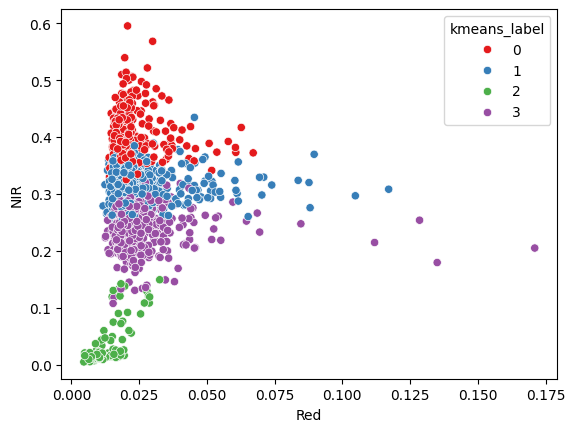

In [ ]:
# @title Solution
N_CLUSTERS = 4
RANDOM_STATE = 42

# Perform k-means clustering on the sample points

kmeans = KMeans(n_clusters=N_CLUSTERS, # Set the number of clusters
                random_state=RANDOM_STATE).fit(samples_df) # Set the random seed for reproducibility

samples_df['kmeans_label'] = kmeans.labels_

clust_centers = kmeans.cluster_centers_

# Plot Red and NIR bands against each other with cluster centers shown
ax = sns.scatterplot(data=samples_df,
                x='Red',
                y='NIR',
                hue='kmeans_label',
                palette='Set1')


When working with unsupervised learning, it's important not to focus too much on the labels or colors assigned to clusters, as these can vary between runs or with different hyperparameters. Instead, the structure and formation of the clusters themselves are what provide meaningful insights.

In this small sample, we observe a potential vertical variation in the NIR values. While this alone doesn't reveal much, applying the method to the full dataset later on will help uncover more distinct and interpretable patterns.

# Goal 2: Classify the entire Sentinel-2 image using the k-means clusters

Now lets take the techinques we learned before and apply them to the full area. Below you can view the subset window and Clip sentinel-2 imagery to the test area.

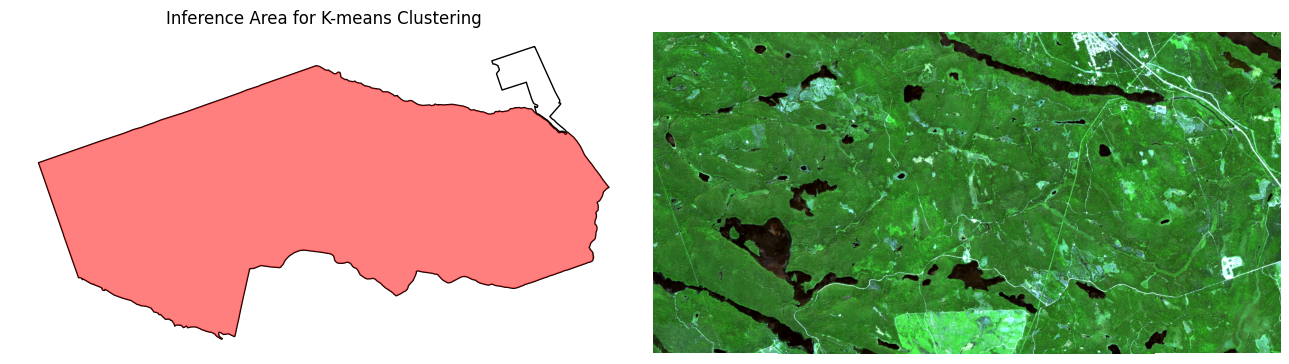

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6.5)) # Adjust figsize as needed

# Plot 1: Inference Area for K-means Clustering
inference_area = boundary_gdf.iloc[1:]
boundary_gdf.plot(color='none', edgecolor='black', ax=axes[0])
inference_area.plot(ax=axes[0], color='red', alpha=0.5)
axes[0].set_title('Inference Area for K-means Clustering')
simplify_plt(axes[0])

# Plot 2: RGB Plot of s2_2018_subset
s2_2018_subset = s2_2018.rio.clip(inference_area.geometry, inference_area.crs)
plot_rgb(s2_2018.values[1:4], ax=axes[1])
simplify_plt(axes[1])

plt.tight_layout()
plt.show()

As always and throughout these tutorials, make sure to check for NAs and replace them with 0s. Including these checks will never hurt your analysis and can prevent unexpected issues down the line.

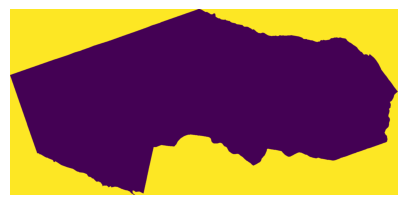

In [ ]:
nan_count_mask = np.isnan(s2_2018_subset.values).sum(axis=0)

fig, ax = plt.subplots(figsize=(5, 5))
show(nan_count_mask, ax=ax)
simplify_plt(ax)

s2_2018_subset = s2_2018_subset.fillna(0)

This code transforms a multi-dimensional satellite image array (s2_2018_subset) into a flat, 2D Pandas DataFrame which is needed for clustering to work.

In [ ]:
n_bands = s2_2018_subset.shape[0]
pixels = s2_2018_subset.values.reshape(n_bands, -1).T
s2_2018_subset_df = (pd.DataFrame(pixels,
                                 columns=samples_df.columns.tolist()[:-1])
                                 )

s2_2018_subset_df

Aerosols  Blue  Green  Red  Red Edge 1  Red Edge 2  Red Edge 3  NIR  \
0             0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   
1             0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   
2             0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   
3             0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   
4             0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   
...           ...   ...    ...  ...         ...         ...         ...  ...   
1591474       0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   
1591475       0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   
1591476       0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   
1591477       0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   
1591478       0.0   0.0    0.0  0.0         0.0         0.0         0.0  0.0   

         Red Edge 4  Water vapor  SWIR 1  SWIR 2  
0               0.0          0.0     0.0     0.0  
1               0.0          0.0     0.0     0.0  
2               0.0          0.0     0.0     0.0  
3               0.0          0.0     0.0     0.0  
4               0.0          0.0     0.0     0.0  
...             ...          ...     ...     ...  
1591474         0.0          0.0     0.0     0.0  
1591475         0.0          0.0     0.0     0.0  
1591476         0.0          0.0     0.0     0.0  
1591477         0.0          0.0     0.0     0.0  
1591478         0.0          0.0     0.0     0.0  

[1591479 rows x 12 columns]

Now that our data is in the correct format, we can Apply k-means clustering to the test area.

**Question 2: Fill in the code below.**

In [ ]:
pred_kmeans = ....predict(s2_2018_subset_df)
pred_kmeans = pred_kmeans.reshape(s2_2018_subset.shape[1:4])
pred_kmeans.shape

In [ ]:
# @title Solution
pred_kmeans = kmeans.predict(s2_2018_subset_df)
pred_kmeans = pred_kmeans.reshape(s2_2018_subset.shape[1:4])
pred_kmeans.shape

(873, 1823)

This code block transforms the K-means clustering predictions (`pred`) back into a geospatial raster format using the existing satellite image (`s2_2018_subset`) as a template. This is so we can view it in its orginal form.

In [ ]:
assert s2_2018_subset.values.shape[1:3] == pred_kmeans.shape, "Shape mismatch between raster and prediction array."

# Assing kmeans labels to the first s2 raster band, then drop all other bands
# This will create a new raster where each pixel is assigned a cluster label

ras_kmeans = s2_2018_subset.copy(deep=True)
ras_kmeans.values[0, :, :] = pred_kmeans
ras_kmeans = ras_kmeans.sel(band=1)
ras_kmeans.attrs["long_name"] = "kmeans_label"

# Finally, clip kmeans ras to the target area
ras_kmeans = ras_kmeans.rio.clip(inference_area.geometry, inference_area.crs)
ras_kmeans

<xarray.DataArray (y: 873, x: 1823)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 15kB 2.973e+05 2.973e+05 ... 3.155e+05 3.155e+05
  * y            (y) float64 7kB 5.098e+06 5.098e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      kmeans_label

We can now plot our clusters and compare the results to the original image.

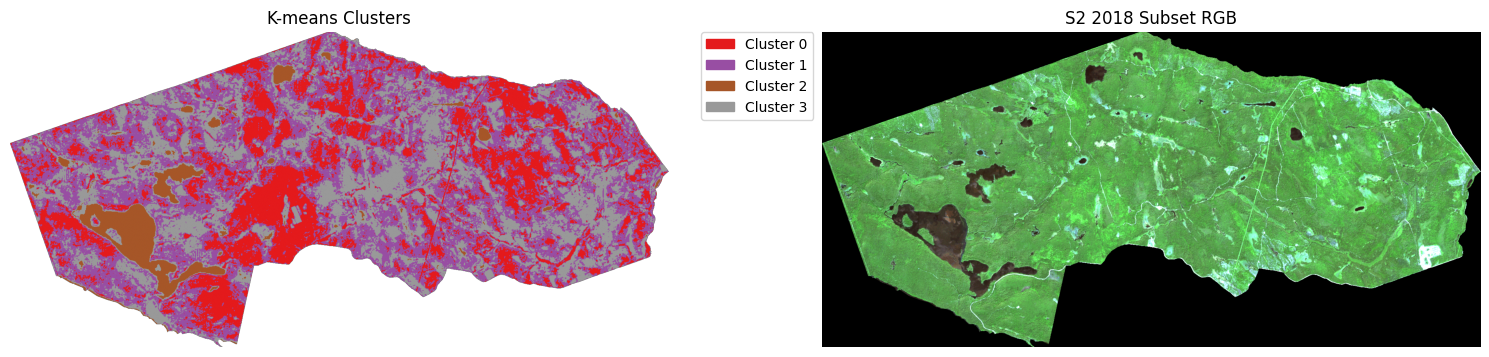

In [ ]:
# Plot pred area and RGB image side by side
# Create a figure with 1 row and 2 columns for side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot 1: K-means Cluster Map
im = ax1.imshow(ras_kmeans.values, cmap='Set1')
ax1.set_title('K-means Clusters')

#build up identifying labels of clusters
unique_labels = np.unique(ras_kmeans.values)
unique_labels = unique_labels[~np.isnan(unique_labels)].astype(int)
colors = [im.cmap(im.norm(label)) for label in unique_labels]
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {label}')
           for i, label in enumerate(unique_labels)]
ax1.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Plot 2: RGB image
plot_rgb(s2_2018_subset.values[1:4], ax=ax2)
ax2.set_title('S2 2018 Subset RGB')

# Simplify
simplify_plt(ax1)
simplify_plt(ax2)

plt.tight_layout()
plt.show()

Another useful piece of information we can get from this is the percentage of the total area each cluster covers.

In [ ]:
# Flatten the array and remove NaN values
labels = ras_kmeans.values.flatten()
labels = labels[~np.isnan(labels)].astype(int)

# Count pixels for each cluster
cluster_counts = np.bincount(labels)
total_pixels = len(labels)

# Calculate percentage for each cluster
cluster_percentages = (cluster_counts / total_pixels) * 100

# Print the results
for i, percentage in enumerate(cluster_percentages):
    print(f"Cluster {i}: {percentage:.2f}%")

Cluster 0: 24.24%
Cluster 1: 42.39%
Cluster 2: 4.65%
Cluster 3: 28.71%


**Question 3 - What are some things you can say about our result? Was the clustering algorithm able to pick up various sections of the orginal image?**

*Answer here*

<details open>
<summary>Solution</summary>


- Water Bodies:
The dark regions in the RGB image (likely water bodies) have been distinctly captured in the clustering output, especially in the large black/dark brown areas in the west and central parts. This shows the algorithm correctly grouped low-reflectance areas.

- Vegetation Variability:
The various shades of green in the RGB image, which represent different types or densities of vegetation, are split into different clusters. This suggests the algorithm is picking up spectral differences that might correspond to different vegetation types or health.

- Potential Human Activity/Developed Areas:
The very bright patch on the RGB image (especially in the bottom right) are not separated into a unique cluster. These may be roads, buildings, or cleared land.

</details>

# Goal 3: Evaluate and Validate Clustering Results

Based on our experiment above, we used 4 clusters to categorize the data. While we cannot say for certain that 4 is the optimal number, how should we go about choosing it? In practice, the number of clusters is often chosen by a domain expert or guided by patterns observed in the data. For example, if your dataset includes 4 known types of trees, it would make sense to cluster into 4 groups.

In our case, we observe what appear to be 4 distinct types of areas on the map. Ideally, we don't "tune" the number of clusters arbitrarily, but instead assess how well the chosen clusters represent the data. One common way to do this is by using the silhouette score.

The silhouette score, also known as the silhouette coefficient, is a metric used to evaluate the quality of clustering results. It provides insight into how well each point fits within its assigned cluster and how distinct the clusters are from one another.

The silhouette score, also known as the silhouette coefficient, is a metric used to evaluate the quality of clustering results. It measures how well each data point fits within its assigned cluster and how distinct that cluster is from others. A higher score indicates well-defined, separated clusters, while a lower score suggests overlapping or poorly formed clusters.

What the Silhouette Score Measures:

For each data point in your dataset, the silhouette score calculates a value that reflects two key aspects:

- Cohesion (a): This measures how similar a point is to other points within its own cluster. It is typically calculated as the average distance from that point to all other points in the same cluster. A smaller value of a indicates the point is well-matched with its cluster, meaning good cohesion.

- Separation (b): This measures how dissimilar a point is from points in the nearest neighboring cluster (the closest cluster it is not part of). It is calculated as the average distance from the point to all points in that neighboring cluster. A larger value of b indicates the point is well-separated from other clusters, meaning good separation.

You can also explore a more visual explanation of this metric here: [Understanding Silhouette Score in Clustering](https://farshadabdulazeez.medium.com/understanding-silhouette-score-in-clustering-8aedc06ce9c4)
. This article offers intuitive visuals that bring the silhouette concept to life.

The provided code prepares the data for a silhouette analysis by first reshaping it into a samples-by-features matrix, `X`. It then cleans the data by removing any rows (pixels) that are either entirely zeros or contain NaN values. The result is a valid and usable dataset, `X_valid`, which serves as the input for clustering algorithms.

Once clustering is performed and cluster labels are assigned, `X_valid` along with the predicted labels is used to calculate the silhouette score. This score evaluates how well the data has been clustered by measuring cohesion within clusters and separation between them.

In [ ]:
# Step 1: Flatten and reshape
X = s2_2018.values.reshape(s2_2018.shape[0], -1).T  # (pixels, bands)

# Step 2: Remove pixels that are all zeros
nonzero_mask_kmeans = ~np.all(X == 0, axis=1)

# Step 3: Remove pixels that contain NaNs
nonan_mask_kmeans = ~np.any(np.isnan(X), axis=1)

# Step 4: Combine both masks
valid_mask_kmeans = nonzero_mask_kmeans & nonan_mask_kmeans

# Step 5: Apply mask
X_valid_kmeans = X[valid_mask_kmeans]

After this setup, we can fit the data using our KMeans model and extract the resulting cluster labels.

In [ ]:
kmeans.fit(X_valid_kmeans)
labels_kmeans = kmeans.labels_

The code below imports two functions from the scikit-learn library's metrics module that are used to evaluate clustering quality:

`silhouette_samples`: Computes the silhouette score for each individual data point in the dataset. This gives a detailed view of how well each sample fits within its cluster compared to other clusters.

`silhouette_score`: Computes the average silhouette score for the entire dataset, summarizing the overall quality of the clustering.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

This code computes the average silhouette score for a sample of the preprocessed data (`X_valid`) and their corresponding cluster labels.

Because calculating the silhouette score on very large datasets can be computationally expensive, the code first selects a random subset of N data points (`X_sample`) along with their associated cluster labels (`labels_sample`) from the full dataset. It then uses the silhouette_score function from sklearn.metrics to calculate the average silhouette score on this smaller sample.

The resulting score provides a single quantitative measure of clustering quality, where a higher score (closer to 1) indicates well-defined, well-separated clusters.

In [ ]:
N = 20000
indices = np.random.choice(len(X_valid_kmeans), min(N, len(X_valid_kmeans)), replace=False)
X_sample = X_valid_kmeans[indices]
labels_sample = labels_kmeans[indices]

score = ...(X_sample, labels_sample)
print(f"Silhouette Score: {score:.4f}")

In [ ]:
# @title Solution
N = 20000
indices = np.random.choice(len(X_valid_kmeans), min(N, len(X_valid_kmeans)), replace=False)
X_sample = X_valid_kmeans[indices]
labels_sample = labels_kmeans[indices]

score = silhouette_score(X_sample, labels_sample)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.4095


A Silhouette Score of around 0.4078 (this can change slightly based on runs) indicates that the clustering is reasonable to weak.

Here's an explaination of what that means:

Range: The Silhouette Score ranges from -1 to +1.

- +1: Indicates that data points are well-matched to their own cluster and poorly matched to neighboring clusters. This is ideal, meaning clusters are distinct and cohesive.

- 0: Suggests that data points are on or very close to the decision boundary between two neighboring clusters, indicating overlap.

- -1: Means that data points might have been assigned to the wrong cluster, as they are more similar to a different cluster than their assigned one.

Interpretation of  0.4078:

- It's a positive score, which is good. It means that, on average, your data points are closer to other points in their own cluster than to points in neighboring clusters.

- However, it's generally considered to be in the "weak" to "reasonable" range.

- Scores above 0.7 are often considered "strong" clustering.

- Scores above 0.5 are typically considered "reasonable" or "good."

- Scores above 0.25 are often considered "acceptable" or "weak."

We can create a silhouette plot to visualize the quality of our clusters.

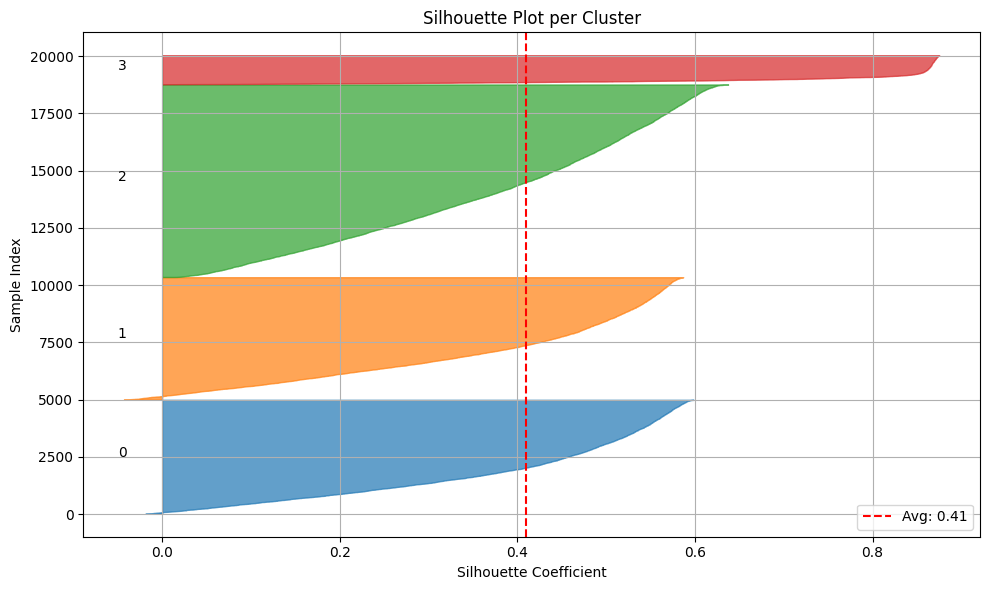

In [ ]:
sil_values = silhouette_samples(X_sample, labels_sample)

# Sort the silhouette scores per cluster
n_clusters = len(np.unique(labels_sample))
y_lower = 10
plt.figure(figsize=(10, 6))

for i in range(n_clusters):
    ith_sil_values = sil_values[labels_sample == i]
    ith_sil_values.sort()
    size_cluster = ith_sil_values.shape[0]
    y_upper = y_lower + size_cluster

    color = plt.cm.tab10(i)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10  # space between clusters

# Global average line
score = silhouette_score(X_sample, labels_sample)
plt.axvline(x=score, color="red", linestyle="--", label=f"Avg: {score:.2f}")

plt.xlabel("Silhouette Coefficient")
plt.ylabel("Sample Index")
plt.title("Silhouette Plot per Cluster")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


How to Interpret a Silhouette Plot:

Each "wave" or "fan" in the silhouette plot represents a cluster.

**Width of the Silhouette Wave (Cohesion and Separation):**  
- **Thick and wide waves extending far to the right (towards +1):**  
    Indicate that points within the cluster are very cohesive (similar to each other) and well separated from other clusters. This is a sign of a well-defined cluster.  
- **Thin waves or waves that do not extend far to the right:**  
    Suggest that the cluster has lower cohesion or poor separation from other clusters.

**Length of Individual Silhouette Bars:**  
- **Long bars close to +1:**  
    These data points are well-clustered and clearly belong to their assigned cluster.  
- **Short bars near 0:**  
    These points lie close to the boundary between clusters, indicating ambiguity in their assignment. They can be considered "borderline" points.  
- **Bars extending into the negative region (left of 0):**  
    These points are likely misclassified, as they are more similar to another cluster than their assigned one. Such points should be investigated or may suggest the need to re-evaluate the clustering.

**Consistency of Wave Thickness and Shape:**  
- **Relatively uniform thickness and shape across clusters:**  
    Indicates clusters of similar quality.  
- **Varying thickness or shapes:**  
    Reveals that some clusters are better defined than others, helping identify problematic clusters.

**Position Relative to the Average Silhouette Score (Red Line):**  
- **Clusters with waves mostly to the right of the red average line:**  
    Perform better than the overall average clustering quality.  
- **Clusters with waves mostly to the left of the red line (especially extending into negative):**  
    Perform worse than average and may contain misclassified points.


It is possible that our clustering algorithm has limitations. KMeans may struggle to capture subtle intricacies in the data or, conversely, may be too sensitive, leading to overfitting. Below, we will explore a different clustering algorithm that might perform better, or at least differently, than KMeans.

# Goal 4: MiniBatchKMeans clustering

MiniBatchKMeans is a variation of the traditional K-Means algorithm designed to improve scalability. Instead of using the entire dataset at once, it updates cluster centroids based on small, random subsets of data called "mini-batches."

This stochastic approach makes the algorithm less sensitive to outliers and fine-grained nuances in the data, which may lead to better classification results. Additionally, because MiniBatchKMeans runs much faster, it allows for many more iterations compared to standard K-Means, potentially improving the clustering quality.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

Similar to K-Means, we will begin by preparing the data for classification, followed by performing the clustering.

**Question 1: Fill in the code below.**

In [ ]:
# 1. Flatten raster data
bands, height, width = s2_2018_subset.values.shape
X = s2_2018_subset.values.reshape(bands, -1).T  # Shape: (pixels, bands)

# 2. Normalize (this step is important for clustering)
X_scaled_mbK = ...().fit_transform(X)

# 3. Apply MiniBatchKMeans
kmeans_mbK = ...(n_clusters=N_CLUSTERS, batch_size=2048, random_state=RANDOM_STATE)
labels_mbK = ....fit_predict(X_scaled_mbK)

# 4. Reshape labels back to raster shape
pred_mbK = ....reshape((height, width))

In [ ]:
# @title Solution
# 1. Flatten raster data
bands, height, width = s2_2018_subset.values.shape
X = s2_2018_subset.values.reshape(bands, -1).T  # Shape: (pixels, bands)

# 2. Normalize (this step is important for clustering)
X_scaled_mbK = StandardScaler().fit_transform(X)

# 3. Apply MiniBatchKMeans
kmeans_mbK = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=2048, random_state=RANDOM_STATE)
labels_mbK = kmeans_mbK.fit_predict(X_scaled_mbK)

# 4. Reshape labels back to raster shape
pred_mbK = labels_mbK.reshape((height, width))

After classification, we assign the predicted labels back to the raster format to enable effective plotting.

In [ ]:
# Assign labels to first band of raster copy
ras_mbk = s2_2018_subset.copy(deep=True)
ras_mbk.values[0, :, :] = pred_mbK
ras_mbk = ras_mbk.sel(band=1)  # Select only the labeled band
ras_mbk.attrs["long_name"] = "minibatch_kmeans_label"

# clip to inference area
ras_mbk = ras_mbk.rio.clip(inference_area.geometry, inference_area.crs)

Now that we have all the data, we can plot each clustering result side by side. Since each classification algorithm assigns cluster colors arbitrarily, maintaining color consistency across plots is difficult. However, the key is to focus on the shapes and spatial patterns of the clusters to empirically assess how well the clustering fits the data.

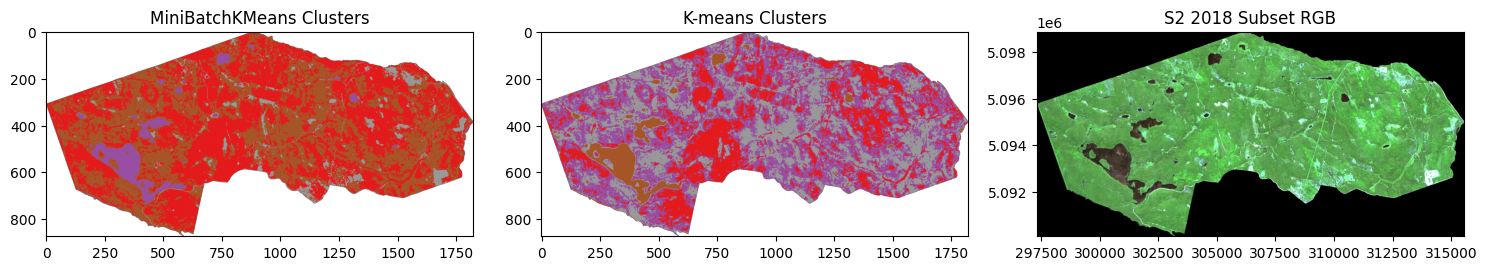

In [ ]:
# Create a figure with 1 row and 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

#Plot 1: MiniBatchKMeans
im = ax1.imshow(ras_mbk.values, cmap='Set1')
ax1.set_title('MiniBatchKMeans Clusters')

#Plot 2: MiniBatchKMeans
im = ax2.imshow(ras_kmeans.values, cmap='Set1') # Use a colormap suitable for discrete labels
ax2.set_title('K-means Clusters') # Add a title for clarity

# Plot 3: RGB Plot of s2_2018_subset
plot_rgb(s2_2018_subset.values[1:4], ax=ax3)
ax3.set_title('S2 2018 Subset RGB') # Add a title for clarity

# Improve layout
plt.tight_layout()
plt.show()

Looking at the images below, we can observe subtle differences between the two clustering results. The very bright spot in the bottom right of the RGB image also now appears in the MiniBatchKMeans clustering. K-Means tends to be quite sensitive to patterns in the data, creating many small clusters around the islands visible in the RGB photo. In contrast, MiniBatchKMeans produces a more “loose” clustering, which may or may not better reflect the real-world area.

To determine which model provides a better fit for the data, let's perform another silhouette test!

| MiniBatchKMeans Excerpt | K-means Excerpt | S2 2018 Subset RGB |
|--------|--------|--------|
| <img src="https://drive.google.com/uc?id=1oi8sy7Xlc5mQbL5a6UxsRL4WMrz9G3oE" width="500"/> | <img src="https://drive.google.com/uc?id=1tc2dL-WKyBQvVIhxDhW0KB6KdrITS1AG" width="500"/> | <img src="https://drive.google.com/uc?id=1DseRKz6s8U1caKLHbaHDxM784W1KcvZr" width="500"/> |
| [See full-size image](https://drive.google.com/uc?id=1oi8sy7Xlc5mQbL5a6UxsRL4WMrz9G3oE) | [See full-size image](https://drive.google.com/uc?id=1tc2dL-WKyBQvVIhxDhW0KB6KdrITS1AG) | [See full-size image](https://drive.google.com/uc?id=1DseRKz6s8U1caKLHbaHDxM784W1KcvZr) |


As with the previous test, the raster data is flattened so that each pixel is represented as a feature vector of its spectral bands and then standardized to improve clustering performance. MiniBatchKMeans efficiently assigns each pixel to a cluster, grouping similar land cover types.

Since computing the silhouette score on the full dataset is computationally expensive, a random sample of 20,000 pixels is used to evaluate clustering quality. The silhouette score measures how well-separated and compact the resulting clusters are. `resample` is used for this.

In [ ]:
from sklearn.utils import resample
# Step 1: Flatten the raster and scale it
bands, height, width = s2_2018_subset.values.shape
X = s2_2018_subset.values.reshape(bands, -1).T  # shape: (pixels, bands)
X_scaled = ...().fit_transform(X)

# Step 2: Fit MiniBatchKMeans
kmeans_mbK = ...(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, batch_size=2048)
labels = ....fit_predict(X_scaled)

# Step 3: Sample data to make silhouette computation feasible
X_sample, labels_sample = resample(X_scaled, labels, n_samples=20000, random_state=RANDOM_STATE)

# Step 4: Compute silhouette score
score = silhouette_score(X_sample, labels_sample)
print(f"Silhouette Score: {score:.4f}")

In [ ]:
# @title Solution
# Step 1: Flatten the raster and scale it
bands, height, width = s2_2018_subset.values.shape
X = s2_2018_subset.values.reshape(bands, -1).T  # shape: (pixels, bands)
X_scaled = StandardScaler().fit_transform(X)

# Step 2: Fit MiniBatchKMeans
kmeans_mbK = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, batch_size=2048)
labels = kmeans_mbK.fit_predict(X_scaled)

# Step 3: Sample data to make silhouette computation feasible
X_sample, labels_sample = resample(X_scaled, labels, n_samples=20000, random_state=RANDOM_STATE)

# Step 4: Compute silhouette score
score = silhouette_score(X_sample, labels_sample)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.5847


It looks like we achieved a better silhouette score with MiniBatchKMeans compared to KMeans! This suggests that the clusters from this model better fit the data. To ensure the number of clusters isn't influencing this result, let's evaluate silhouette scores across various cluster sizes using an elbow test. This may take about 1.5 minutes to run.

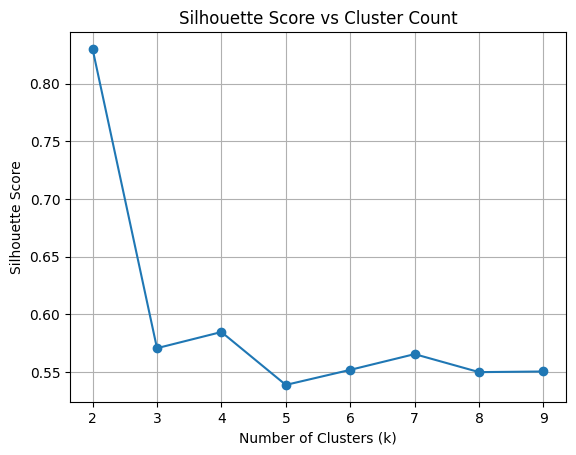

In [ ]:
scores = []
ks = range(2, 10)

for k in ks:
    mbK = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, batch_size=2048)
    labels_k = mbK.fit_predict(X_scaled)
    X_s, y_s = resample(X_scaled, labels_k, n_samples=20000, random_state=RANDOM_STATE)
    score = silhouette_score(X_s, y_s)
    scores.append(score)

# Plot results
plt.plot(ks, scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Cluster Count")
plt.grid(True)
plt.show()

This method is known as the elbow test. Ideally, you select the number of clusters at the 'elbow' point of the graph, imagine the curve as a bent arm. In this case, 3 or 4 clusters are potential candidates, but since 4 has a higher silhouette score, it seems our initial choice of 4 clusters was appropriate. While expert knowledge is valuable when deciding the number of clusters, the elbow test serves as a useful sanity check when expert guidance is unavailable or when you want to validate your choice.

Now let’s create the silhouette plot again to evaluate how our MiniBatchKMeans clustering performs.

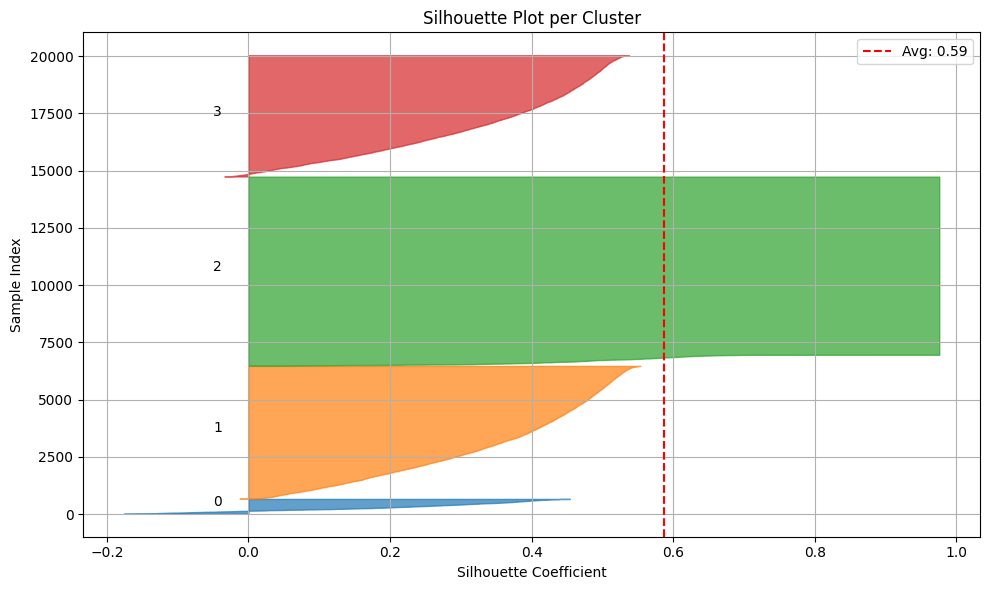

In [ ]:
sil_values = silhouette_samples(X_sample, labels_sample)

# Sort the silhouette scores per cluster
n_clusters = len(np.unique(labels_sample))
y_lower = 10
plt.figure(figsize=(10, 6))

for i in range(n_clusters):
    ith_sil_values = sil_values[labels_sample == i]
    ith_sil_values.sort()
    size_cluster = ith_sil_values.shape[0]
    y_upper = y_lower + size_cluster

    color = plt.cm.tab10(i)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10  # space between clusters

# Global average line
score = silhouette_score(X_sample, labels_sample)
plt.axvline(x=score, color="red", linestyle="--", label=f"Avg: {score:.2f}")

plt.xlabel("Silhouette Coefficient")
plt.ylabel("Sample Index")
plt.title("Silhouette Plot per Cluster")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The silhouette plot shows the distribution of silhouette coefficients for each cluster along the sample index. The average silhouette score is approximately 0.59, indicating a generally good clustering quality. Most clusters have silhouette values spread mostly between 0.2 and 0.8, suggesting that most data points are reasonably well-clustered. However, one cluster contains a portion of points with silhouette scores near or below zero, which may indicate some misclassified samples or outliers in that cluster.

In summary, we applied MiniBatchKMeans clustering to our dataset and evaluated its performance using a silhouette plot. The results showed an average silhouette score of about 0.59, indicating generally good cluster separation. Most clusters had silhouette values between 0.2 and 0.8, suggesting that points were well-assigned, though one cluster contained samples with scores near or below zero, hinting at possible misclassifications or outliers. Overall, the MiniBatchKMeans approach delivered strong results while offering faster computation compared to standard KMeans.

# Goal 6: Classifying the Sentinel-2 image change between 2018 and 2024

As a final quick experiment, we can classify the image for two different years and compare the results to identify changes over time. This approach is useful when we want to detect differences between two time periods without knowing exactly what has changed in advance.

Below is a few cells to help get our data and process it for clustering.

Load 2024 data

In [ ]:
s2_2024_fpath = 'data/petawawa_s2_2024.tif'
s2_2024 = rio.open_rasterio(s2_2024_fpath)

# Reproject boundary to match CRS (if needed)
boundary_gdf = boundary_gdf.to_crs(s2_2024.rio.crs)

Clip both rasters to boundary

In [ ]:
s2_2018_clip = s2_2018.rio.clip(boundary_gdf.geometry.values, boundary_gdf.crs, drop=True)
s2_2024_clip = s2_2024.rio.clip(boundary_gdf.geometry.values, boundary_gdf.crs, drop=True)

# Convert to (height, width, bands)
s2_2018_np = s2_2018_clip.values.transpose(1, 2, 0)
s2_2024_np = s2_2024_clip.values.transpose(1, 2, 0)

This is a helper function which flattens your multi-band raster data into a 2D array where each row is a pixel and each column is a spectral band, then removes any rows that contain NaN values.

In [ ]:
def prepare_for_clustering(arr):
    flat = arr.reshape(-1, arr.shape[-1])
    # Remove rows with NaNs
    return flat[~np.isnan(flat).any(axis=1)]

X_2018 = prepare_for_clustering(s2_2018_np)
X_2024 = prepare_for_clustering(s2_2024_np)

Now lets use MiniBatchKMeans!

In [ ]:
kmeans_2018 = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=2048, random_state=RANDOM_STATE).fit(X_2018)
kmeans_2024 = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=2048, random_state=RANDOM_STATE).fit(X_2024)

This code converts clustering results from 2018 and 2024 satellite imagery into 2D raster maps, preserving the original spatial layout while marking invalid areas with NaNs for analysis and visualization.

In [ ]:
def labels_to_raster(cluster_model, original, mask_shape):
    # Create a full-sized label map with NaNs for masked areas
    label_map = np.full((original.shape[0] * original.shape[1]), np.nan)
    valid = ~np.isnan(original.reshape(-1, original.shape[2])).any(axis=1)
    label_map[valid] = cluster_model.labels_
    return label_map.reshape(original.shape[:2])

labels_2018_raster = labels_to_raster(kmeans_2018, s2_2018_np, s2_2018_np.shape[:2])
labels_2024_raster = labels_to_raster(kmeans_2024, s2_2024_np, s2_2024_np.shape[:2])

This code aligns the 2024 clustering results with the 2018 clusters using a majority-vote approach, ensuring consistent label meaning between years. It works by comparing corresponding pixels in the two rasters (ignoring NaNs), determining for each 2024 cluster which 2018 cluster label occurs most frequently in the same locations, and creating a mapping between them. This mapping is then applied to relabel the 2024 clusters so that they match the 2018 label definitions, making year-to-year comparisons meaningful.

In [ ]:
# Align 2024 clusters to 2018 using majority voting
from scipy.stats import mode
def align_clusters_by_majority(reference_raster, target_raster):
    aligned = np.full_like(target_raster, np.nan)

    # Flatten and mask NaNs
    valid_mask = ~np.isnan(reference_raster) & ~np.isnan(target_raster)
    ref_flat = reference_raster[valid_mask].astype(int)
    tgt_flat = target_raster[valid_mask].astype(int)

    mapping = {}
    unique_tgt_labels = np.unique(tgt_flat)

    for tgt_label in unique_tgt_labels:
        mask = tgt_flat == tgt_label
        matching_ref_labels = ref_flat[mask]
        if len(matching_ref_labels) > 0:
            # The fix is here: use .item() for robust scalar extraction
            most_common_label = mode(matching_ref_labels, axis=None).mode.item()
            mapping[tgt_label] = most_common_label

    for tgt_label, ref_label in mapping.items():
        aligned[target_raster == tgt_label] = ref_label

    return aligned, mapping

labels_2024_aligned, cluster_mapping = align_clusters_by_majority(labels_2018_raster, labels_2024_raster)

Now that we have the aligned rasters, we can compute the difference between 2024 and 20218 to highlight changes between the two years.

**Question 1: fill in the code below.**

In [ ]:
change_map = ... - ...

change_map[np.isnan(change_map)] = 0  # clean up

In [ ]:
# @title Solution
change_map = labels_2024_aligned - labels_2018_raster

change_map[np.isnan(change_map)] = 0  # clean up

Lets plot the differences between the 2 years!

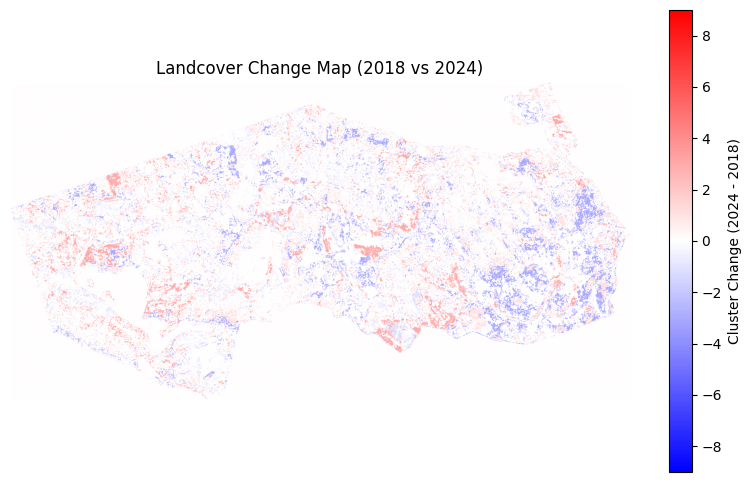

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(change_map, cmap='bwr', vmin=-k, vmax=k)
plt.colorbar(label='Cluster Change (2024 - 2018)')
plt.title('Landcover Change Map (2018 vs 2024)')
plt.axis('off')
plt.show()

This plot can be interpreted as follows:

- White areas = no change

- Red areas = label value increased

- Blue areas = labels value  decreased

However, these changes have no direct semantic meaning because we do not know what the labels represent (e.g., water, flatlands, vegetation). While this plot is useful for detecting whether a change has occurred in a region, determining what those changes actually mean requires mapping labels to real-world classes or clusters. This mapping would be an interesting extension to explore in further experiments.

Below is a grayscale plot that makes it easier to see the areas of change, with any bright spot indicating a change in cluster labels between 2018 and 2024.

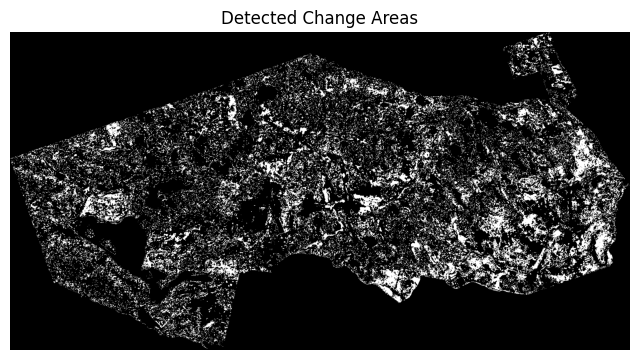

In [ ]:
change_mask = (change_map != 0).astype(int)

plt.figure(figsize=(8, 6))
plt.imshow(change_mask, cmap='gray')
plt.title('Detected Change Areas')
plt.axis('off')
plt.show()

In summary, the core achievement of this work was developing a reliable method to align cluster labels between two different years of satellite imagery (2018 and 2024). This alignment technique is a crucial step for performing meaningful comparisons over time.

While the subsequent change analysis did not yield meaningful real-world results (because the cluster labels were not mapped to specific land cover types like "forest" or "water"), the methodology itself is a valuable takeaway. The ability to align unsupervised clustering labels across different datasets lays a strong foundation for future experiments where these labels could be interpreted. The aligned change map, even without semantic meaning, successfully identified regions where a change occurred, which is a useful preliminary result.

## References

Gemini. (2025). Assistance is editing writeups and code. Retrieved from https://gemini.google.com